# 住宅価格の予測（Advanced Version）

## 1. 必要なモジュールの読み込み

In [2]:
import numpy as np
import pandas as pd 
import scipy as sp
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.formula.api as smf
import statsmodels.api as sm

%matplotlib inline

## 2. データの読み込み

In [3]:
# データを読み込んで変数 data に格納
data=pd.read_csv('dataset/kaggle_housing_price.csv')

In [4]:
# データの最初の5行だけ表示
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


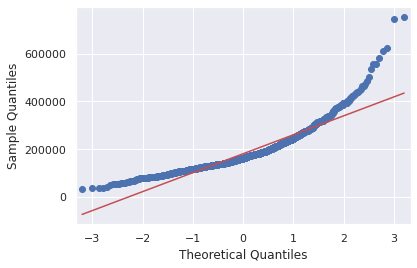

In [5]:
# SalePriceについて Q-Qプロットを表示して正規性を確認　
fig = sm.qqplot(data['SalePrice'], line = 's')

In [6]:
#　NumPy の log1p を用いて全てのデータの対数変換を実施　
data['SalePrice'] = np.log1p(data['SalePrice'])

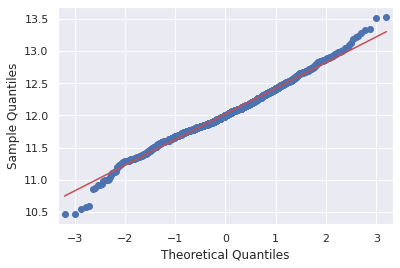

In [7]:
#　対数変換をした後のデータで再度Q-Qプロットを作成し、表示
fig = sm.qqplot(data['SalePrice'], line = 's')

In [8]:
pd.set_option('display.max_rows', None) #このコマンドによって、出力画面で「・・・」で省略されるのを防ぎ、全部詳細を表示できるようにした。

# 　欠損値の数を調査して、表示する

all_data_na = (data.isnull().sum() / len(data)) * 100


#pd.DataFrame({'キー名':値})とする
missing_data=pd.DataFrame({'Missing_Ratio':all_data_na})

missing_data

ku_haku=missing_data.query('Missing_Ratio>0') #　>=だと0も含まれてしまう
ku_haku


,Missing_Ratio
LotFrontage,17.739726
Alley,93.767123
MasVnrType,0.547945
MasVnrArea,0.547945
BsmtQual,2.534247
BsmtCond,2.534247
BsmtExposure,2.602740
BsmtFinType1,2.534247
BsmtFinType2,2.602740
Electrical,0.068493


In [9]:
# PoolQCのNAを文字列 "None" で置換する

data["PoolQC"] = data["PoolQC"].fillna("None")

In [10]:
# PoolQCのNAが"None"で置換されたことを確認する
data["PoolQC"]

0       None
1       None
2       None
3       None
4       None
5       None
6       None
7       None
8       None
9       None
10      None
11      None
12      None
13      None
14      None
15      None
16      None
17      None
18      None
19      None
20      None
21      None
22      None
23      None
24      None
25      None
26      None
27      None
28      None
29      None
30      None
31      None
32      None
33      None
34      None
35      None
36      None
37      None
38      None
39      None
40      None
41      None
42      None
43      None
44      None
45      None
46      None
47      None
48      None
49      None
50      None
51      None
52      None
53      None
54      None
55      None
56      None
57      None
58      None
59      None
60      None
61      None
62      None
63      None
64      None
65      None
66      None
67      None
68      None
69      None
70      None
71      None
72      None
73      None
74      None
75      None
76      None

In [11]:
data.groupby("Neighborhood")['LotFrontage'].median()

Neighborhood
Blmngtn    43.0
Blueste    24.0
BrDale     21.0
BrkSide    52.0
ClearCr    80.0
CollgCr    70.0
Crawfor    74.0
Edwards    65.5
Gilbert    65.0
IDOTRR     60.0
MeadowV    21.0
Mitchel    73.0
NAmes      73.0
NPkVill    24.0
NWAmes     80.0
NoRidge    91.0
NridgHt    88.5
OldTown    60.0
SWISU      60.0
Sawyer     71.0
SawyerW    66.5
Somerst    73.5
StoneBr    61.5
Timber     85.0
Veenker    68.0
Name: LotFrontage, dtype: float64

In [12]:
# LotFrontageのNAを、近隣の家（Neighborhood）単位でLotFrontageのmedianを取って、その値で埋める

data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))


In [13]:
# LotFrontageのNAが近隣の家々のLotFrontageのmedianで置換されたことを確認
data["LotFrontage"]

0        65.0
1        80.0
2        68.0
3        60.0
4        84.0
5        85.0
6        75.0
7        80.0
8        51.0
9        50.0
10       70.0
11       85.0
12       71.0
13       91.0
14       73.0
15       51.0
16       73.0
17       72.0
18       66.0
19       70.0
20      101.0
21       57.0
22       75.0
23       44.0
24       71.0
25      110.0
26       60.0
27       98.0
28       47.0
29       60.0
30       50.0
31       71.0
32       85.0
33       70.0
34       60.0
35      108.0
36      112.0
37       74.0
38       68.0
39       65.0
40       84.0
41      115.0
42       66.5
43       70.0
44       70.0
45       61.0
46       48.0
47       84.0
48       33.0
49       66.0
50       65.0
51       52.0
52      110.0
53       68.0
54       60.0
55      100.0
56       24.0
57       89.0
58       66.0
59       60.0
60       63.0
61       60.0
62       44.0
63       50.0
64       70.0
65       76.0
66       73.0
67       72.0
68       47.0
69       81.0
70       95.0
71    

In [14]:
threshold = 0.8    # 相関係数が threshold に設定した数値以上だった場合、その変数を取り除く

In [15]:
# data から相関行列（Correlation Matrix）を作成して表示する。その際、絶対値を適用して負の値をプラスに変換すること
corr_matrix = data.corr().abs()
corr_matrix.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,0.003381,0.033226,0.028365,0.012609,0.012713,0.021998,0.050298,0.005024,...,0.029643,0.000477,0.002889,0.046635,0.001330,0.057044,0.006242,0.021172,0.000712,0.017942
MSSubClass,0.011156,1.000000,0.370367,0.139781,0.032628,0.059316,0.027850,0.040581,0.022936,0.069836,...,0.012579,0.006100,0.012037,0.043825,0.026030,0.008283,0.007683,0.013585,0.021407,0.073959
LotFrontage,0.003381,0.370367,1.000000,0.335957,0.239546,0.043595,0.120999,0.084550,0.196825,0.232576,...,0.088736,0.141734,0.008057,0.064654,0.041063,0.174567,0.005332,0.007370,0.004756,0.353288
LotArea,0.033226,0.139781,0.335957,1.000000,0.105806,0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,0.014261,0.257320
OverallQual,0.028365,0.032628,0.239546,0.105806,1.000000,0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,0.113937,0.030371,0.064886,0.065166,0.031406,0.070815,0.027347,0.817185


In [16]:
# 対角線上は絶対に 1 になること、および、対角線より下の部分は、上の部分と情報が重複していることから
# 相関行列を上三角行列に変換 
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,NaN,0.011156,0.003381,0.033226,0.028365,0.012609,0.012713,0.021998,0.050298,0.005024,...,0.029643,0.000477,0.002889,0.046635,0.001330,0.057044,0.006242,0.021172,0.000712,0.017942
MSSubClass,NaN,NaN,0.370367,0.139781,0.032628,0.059316,0.027850,0.040581,0.022936,0.069836,...,0.012579,0.006100,0.012037,0.043825,0.026030,0.008283,0.007683,0.013585,0.021407,0.073959
LotFrontage,NaN,NaN,NaN,0.335957,0.239546,0.043595,0.120999,0.084550,0.196825,0.232576,...,0.088736,0.141734,0.008057,0.064654,0.041063,0.174567,0.005332,0.007370,0.004756,0.353288
LotArea,NaN,NaN,NaN,NaN,0.105806,0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,0.014261,0.257320
OverallQual,NaN,NaN,NaN,NaN,NaN,0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,0.113937,0.030371,0.064886,0.065166,0.031406,0.070815,0.027347,0.817185


In [17]:
# 上三角行列から SalePrice以外の列について threshold 以上の値が1つ以上ある列を抽出。その「削除すべき変数」の名前および総数を表示する
# （→これを除去すべき変数と判断します）
to_drop = [column for column in upper.columns if column != 'SalePrice' if any(upper[column] > threshold)]

print('削除する変数：', to_drop)
print('削除する変数の数：', len(to_drop))

削除する変数： ['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea']
削除する変数の数： 4


In [18]:
# data から削除する変数を削除して data_dropped に格納し、data_dropped の内容を表示する
data_dropped = data.drop(columns = to_drop)
data_dropped.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,None,NaN,NaN,0,2,2008,WD,Normal,12.247699
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,None,NaN,NaN,0,5,2007,WD,Normal,12.109016
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,None,NaN,NaN,0,9,2008,WD,Normal,12.317171
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,None,NaN,NaN,0,2,2006,WD,Abnorml,11.849405
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,None,NaN,NaN,0,12,2008,WD,Normal,12.429220


# ダミー変数化

In [1]:
data_dummied = pd.get_dummies(data_dropped)

NameError: name 'pd' is not defined

In [22]:
# ダミー変数化されたことを確認
data_dummied.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,1,0,0,0,0,1,0
